# 1. Import Libraries

In [64]:
# data management libraries
import pandas as pd

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import style
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, make_scorer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import os
import time
import joblib

#always :)
style.use("dark_background") 

# 2. Read Data 

In [65]:
df = pd.read_csv('data/transactions.csv')
df.head()

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0


In [66]:
# check for missing values
df.isnull().sum()

step           0
customer       0
age            0
gender         0
zipcodeOri     0
merchant       0
zipMerchant    0
category       0
amount         0
fraud          0
dtype: int64

# 3. EDA

**Features:** 
- **Step:**  
    Represents the day when the transaction happened. There is a total of 180 steps, so the data runs for six months. This field will be **dropped** since its non significant.
- **Customer:**  
    Represents the unique ID of the person who initialized the transaction. It is formed by the letter `C`, followed by a unique sequence of 10 numbers. There is a total of 4,109 unique customers available in the dataset, so this will also be dropped, since the algorithm shouldn't be biased against any customer id.
- **Age:**  
    This variable is split into age intervals, starting from 0 to 6, and the letter `U` which stands for Unknown. Age is Unknown only for transactions that have the gender equal to Enterprise. The coding for the numbers is:  
    - `0`: less than 18 years old  
    - `1`: between 19 and 25 years old  
    - `2`: between 26 and 35 years old  
    - `3`: between 36 and 45 years old  
    - `4`: between 46 and 55 years old  
    - `5`: between 56 and 65 years old  
    - `6`: older than 65 years old  
    - `7`: `U` will be mapped to `7` for numerical encoding purposes. 
- **Gender:**  
    This variable is coded as `F` for Female, `M` for Male, `E` for Enterprise, and `U` for Unknown. The Unknown group has around 170 customers aged in groups 1, 2, and 3. Unkown gender inputs will be dropped, because they are considered as incomplete entries.
- **Merchant:**  
    Represents the unique ID of the party which receives the transaction. Similar to customer ID, the sequence is formed by the letter `M`, followed by a series of 9 numbers. There is a total of 50 unique merchants in the dataset. This column will also be dropped, since the algorithm shouldn't be biased based on merchant id either.
- **Category:**  
    There are 15 unique categories that label the general type of the transaction:  
    `transportation`, `food`, `health`, `wellness and beauty`, `fashion`, `bars and restaurant`, `hyper`, `sports and toys`, `tech`, `home`, `hotel services`, `other services`, `contents`, `travel`, `leisure`.  
- **Amount:**  
    Represents the value of the transaction. There are only 52 values equal to 0 and no negative values.  
- **Fraud:**  
    A flag column coded with `0` if the transaction was clean and with `1` if the transaction was fraudulent.  
- **zipcodeOri** and **zipMerchant:**  
    These two features will be **removed** from the dataset, as they contained a constant value of `28007`, which is a postal code in Ansonville, North Carolina, United States. 

### 3.1. Preprosessing

In [67]:
# drop the columns that are not significant for clustering
df = df.drop(columns=['step', 'customer', 'merchant', 'zipcodeOri', 'zipMerchant'])

#remove 'es_' from the 'category' column
df['category'] = df['category'].str.replace('es_', '', regex=False)

# remove special symbols from all columns
df = df.replace("^.|.$", '', regex=False)

#drop rows that have 'U' in 'gender' column
df = df[df['gender'] != '\'U\'']

# replace 'U' with '7' in age and convert age from str to int
df['age'] = df['age'].replace('\'U\'', '7').str.strip("'\"").astype(int)

# encode the gender/category columns using one-hot encoding keep the original columns
gender = df['gender']
category = df['category']
df = pd.get_dummies(df, columns=['gender', 'category'])
df['gender_original'] = gender
df['category_original'] = category

In [68]:
df.head()

,age,amount,fraud,gender_'E',gender_'F',gender_'M',category_'barsandrestaurants',category_'contents',category_'fashion',category_'food',...,category_'hyper',category_'leisure',category_'otherservices',category_'sportsandtoys',category_'tech',category_'transportation',category_'travel',category_'wellnessandbeauty',gender_original,category_original
0,4,4.55,0,False,False,True,False,False,False,False,...,False,False,False,False,False,True,False,False,'M','transportation'
1,2,39.68,0,False,False,True,False,False,False,False,...,False,False,False,False,False,True,False,False,'M','transportation'
2,4,26.89,0,False,True,False,False,False,False,False,...,False,False,False,False,False,True,False,False,'F','transportation'
3,3,17.25,0,False,False,True,False,False,False,False,...,False,False,False,False,False,True,False,False,'M','transportation'
4,5,35.72,0,False,False,True,False,False,False,False,...,False,False,False,False,False,True,False,False,'M','transportation'


### 3.2. Plotting

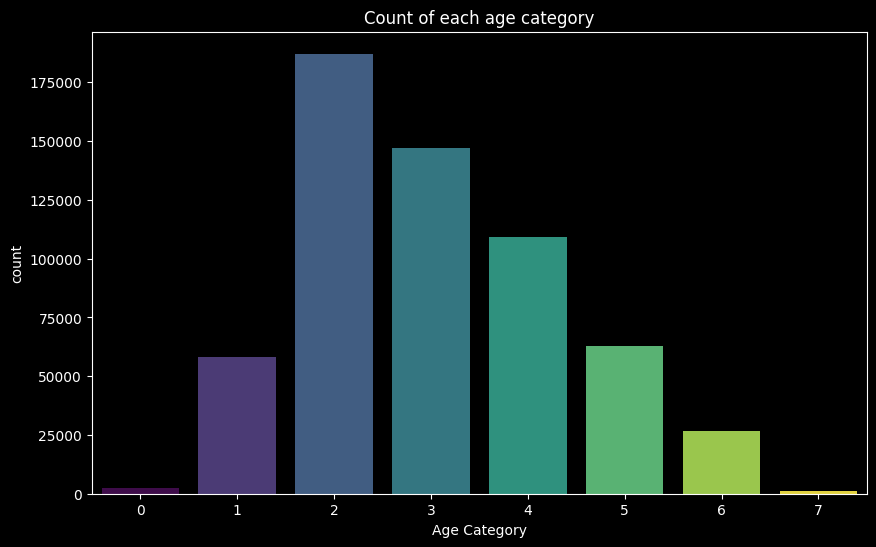

In [69]:
#plot count of each age category
plt.figure(figsize=(10, 6));
sns.countplot(data=df, x='age', hue='age', palette='viridis', legend=False);
plt.title('Count of each age category')
plt.xlabel('Age Category')
plt.show()

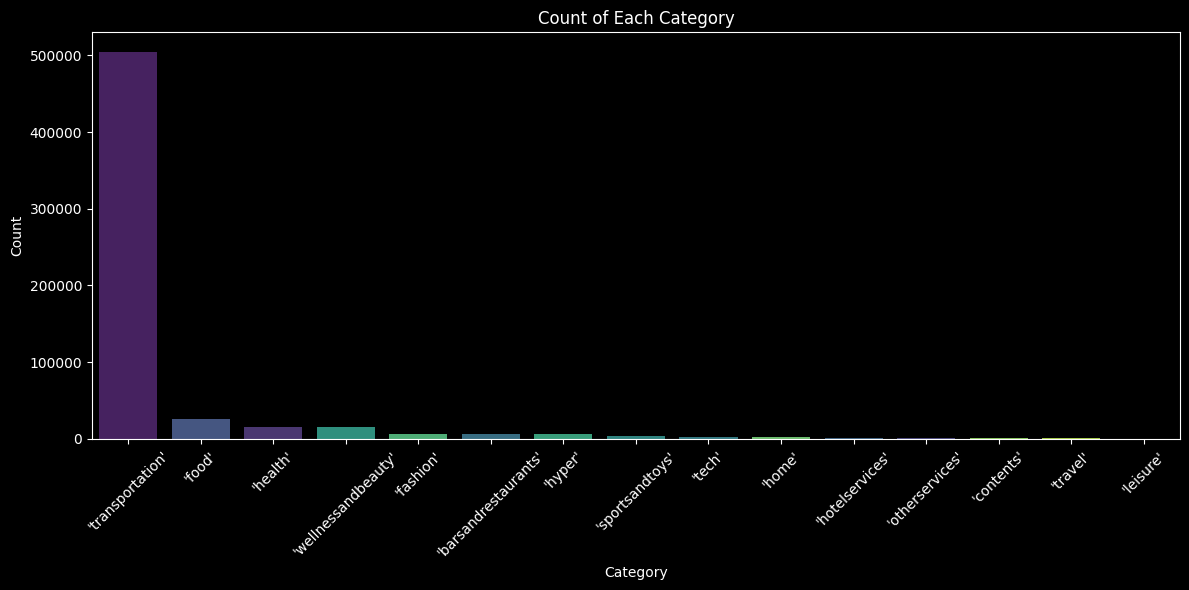

In [70]:
#plot count of each category
plt.figure(figsize=(12, 6))
sns.countplot(data=df, 
    x='category_original', 
    hue='category_original', 
    order=df['category_original'].value_counts().index, 
    palette='viridis', 
    dodge=False)
plt.xlabel('Category')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.title('Count of Each Category')
plt.tight_layout()
plt.show()

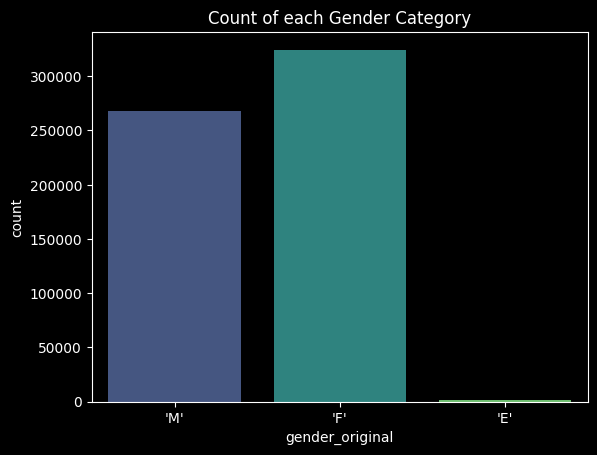

In [71]:
#plot count of each gender
sns.countplot(data=df, x='gender_original', hue='gender_original', palette='viridis', legend=False);
plt.title('Count of each Gender Category')
plt.show()

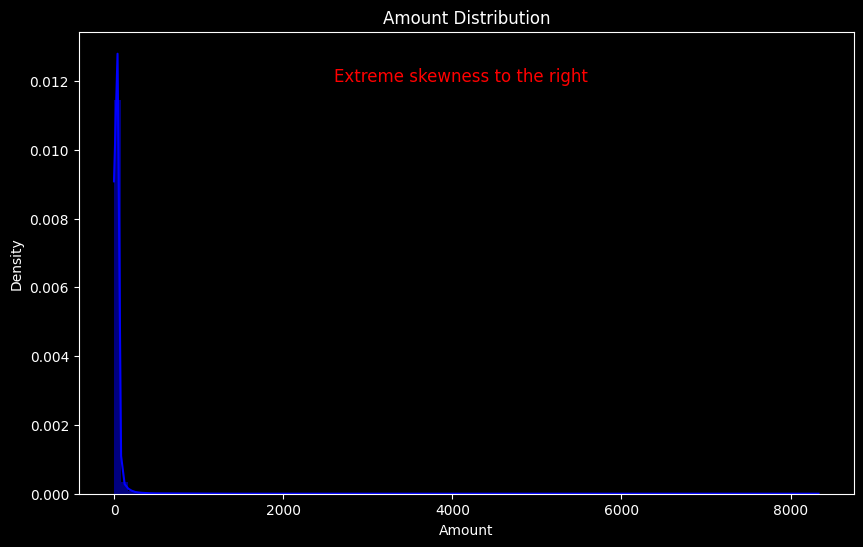

In [72]:
# plot the amount distribution
plt.figure(figsize=(10, 6))
sns.histplot(x=df['amount'], kde=True, color='blue', bins=100, stat='density', linewidth=0, alpha=0.5)
plt.title('Amount Distribution')
plt.xlabel('Amount')
plt.text(x=2600, y=0.012, s='Extreme skewness to the right', fontsize=12, color='red')
plt.show()

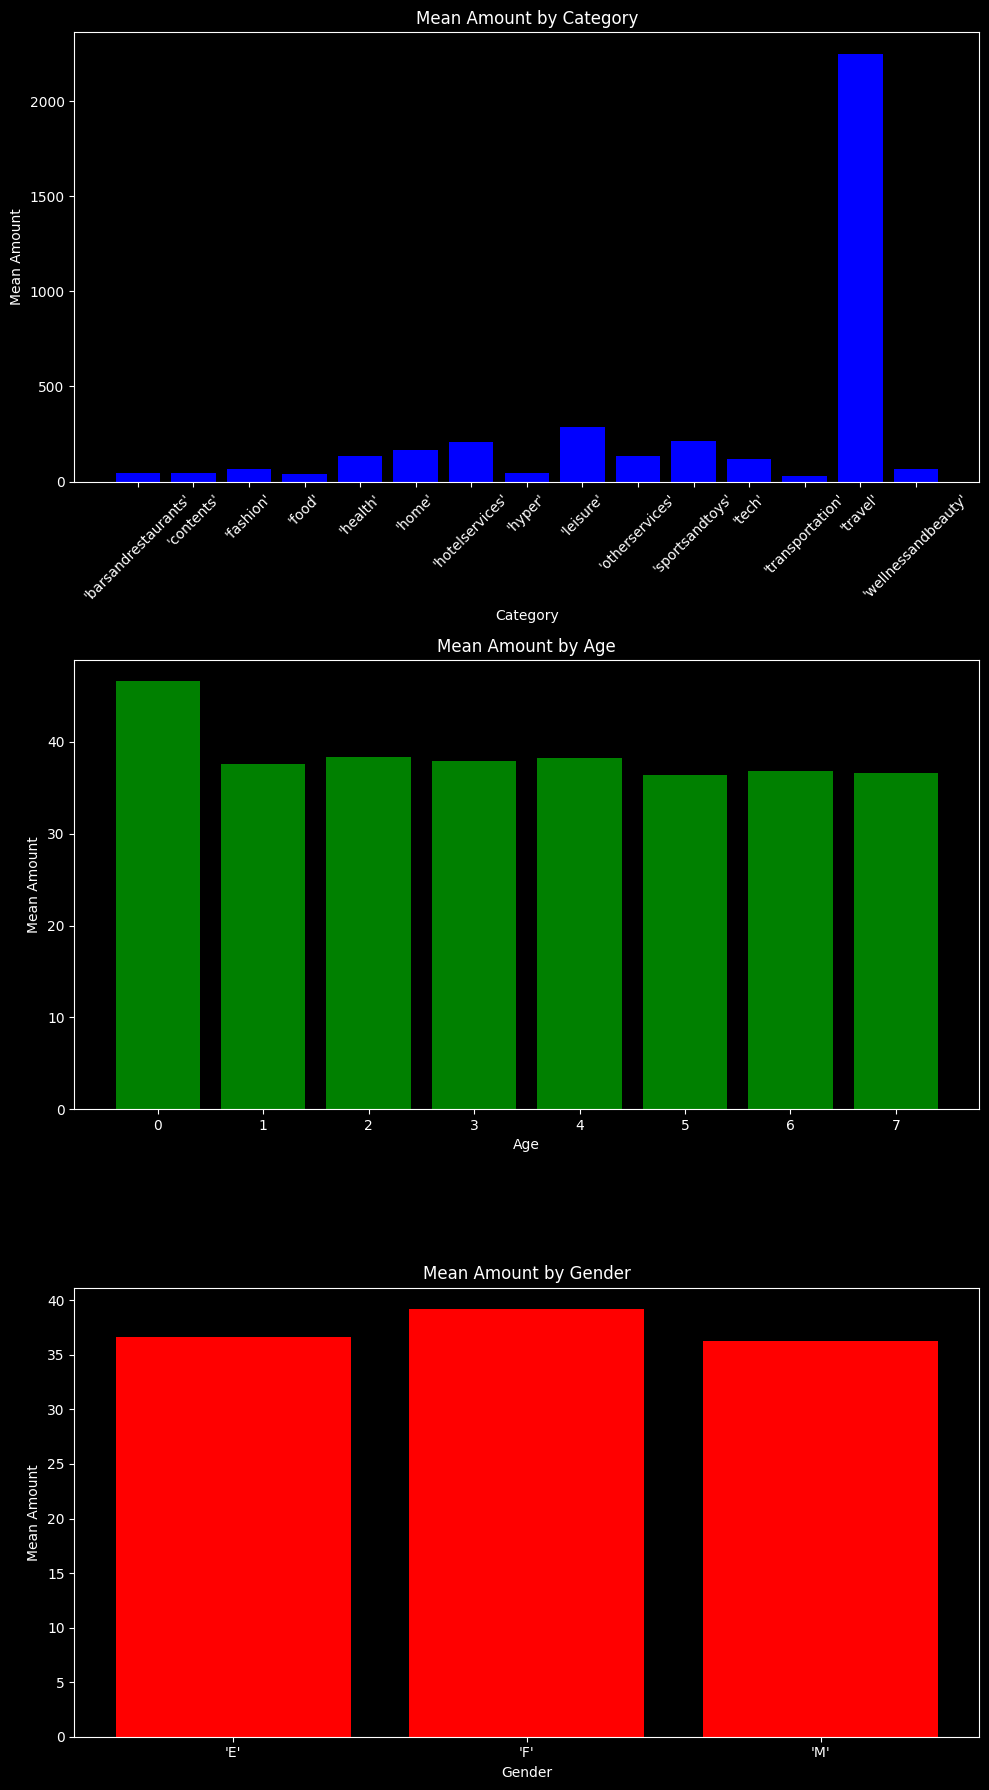

In [73]:
plt.figure(figsize=(10, 18))
plt.subplot(3, 1, 1)
plt.bar(df.groupby('category_original')['amount'].describe().index, df.groupby('category_original')['amount'].describe()['mean'], color='blue')
plt.title('Mean Amount by Category')
plt.xlabel('Category')
plt.xticks(rotation=45)
plt.ylabel('Mean Amount') 
plt.subplot(3, 1, 2)
plt.bar(df.groupby('age')['amount'].describe().index, df.groupby('age')['amount'].describe()['mean'], color='green')
plt.title('Mean Amount by Age')
plt.xlabel('Age')
plt.ylabel('Mean Amount')
plt.subplot(3, 1, 3)
plt.bar(df.groupby('gender_original')['amount'].describe().index, df.groupby('gender_original')['amount'].describe()['mean'], color='red')
plt.title('Mean Amount by Gender')
plt.xlabel('Gender')
plt.ylabel('Mean Amount')
plt.tight_layout()
plt.show()


#### 3.2.1 Fraud Plots

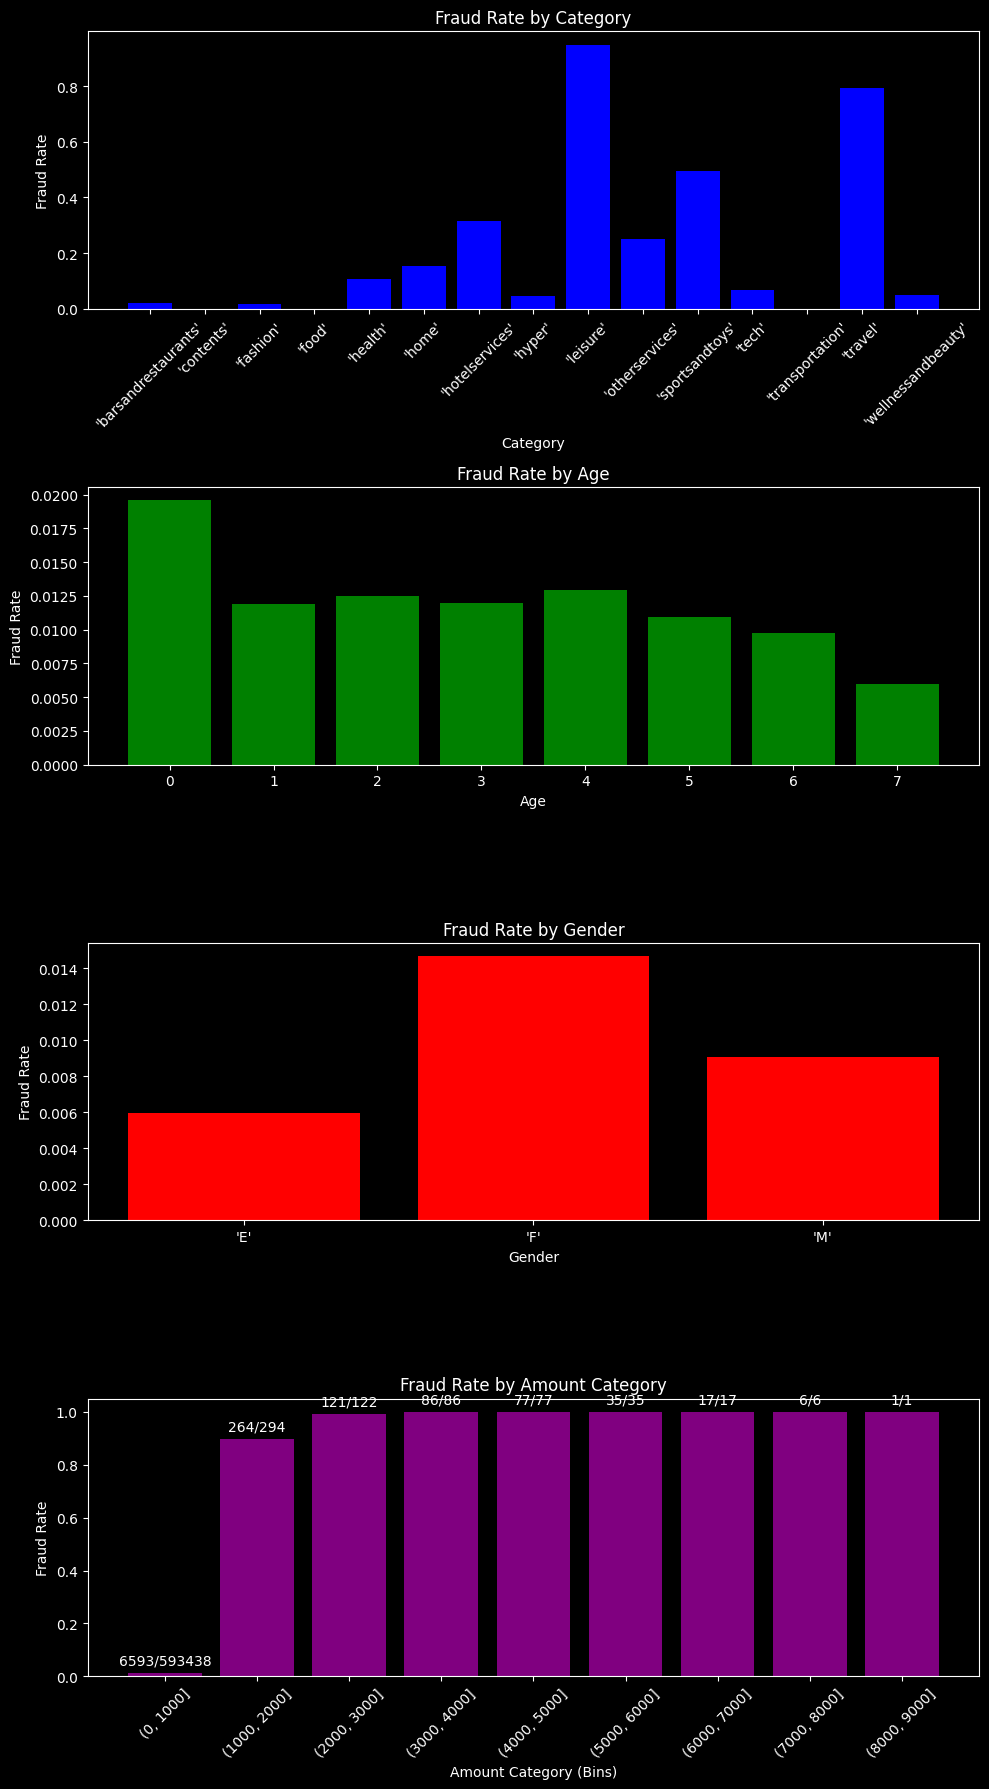

In [74]:
# plot the frauds distribution in corelation with the amount / gender / age / category
plt.figure(figsize=(10, 18))
plt.subplot(4, 1, 1)
plt.bar(df.groupby('category_original')['fraud'].describe().index, df.groupby('category_original')['fraud'].describe()['mean'], color='blue')
plt.title('Fraud Rate by Category')
plt.xlabel('Category')
plt.xticks(rotation=45)
plt.ylabel('Fraud Rate')
plt.subplot(4, 1, 2)
plt.bar(df.groupby('age')['fraud'].describe().index, df.groupby('age')['fraud'].describe()['mean'], color='green')
plt.title('Fraud Rate by Age')
plt.xlabel('Age')
plt.ylabel('Fraud Rate')
plt.subplot(4, 1, 3)
plt.bar(df.groupby('gender_original')['fraud'].describe().index, df.groupby('gender_original')['fraud'].describe()['mean'], color='red')
plt.title('Fraud Rate by Gender')
plt.xlabel('Gender')
plt.ylabel('Fraud Rate')
plt.subplot(4, 1, 4)

# plot the fraud rate by amount, using bins of 1000

amount_bins = pd.cut(df['amount'], bins=range(0, int(df['amount'].max()) + 1000, 1000))
fraud_rate_by_amount = df.groupby(amount_bins,observed=False)['fraud'].mean()
fraud_counts_by_amount = df.groupby(amount_bins, observed=False)['fraud'].sum()
total_counts_by_amount = df.groupby(amount_bins, observed=False)['fraud'].count()

bars = plt.bar(fraud_rate_by_amount.index.astype(str), fraud_rate_by_amount.values, color='purple')

# Annotate each bar with the count of frauds and total inputs
for bar, bin_label in zip(bars, fraud_rate_by_amount.index):
    height = bar.get_height()
    fraud_count = fraud_counts_by_amount[bin_label]
    total_count = total_counts_by_amount[bin_label]
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.02,
             f"{fraud_count}/{total_count}",
             ha='center', va='bottom', fontsize=10)
plt.bar(fraud_rate_by_amount.index.astype(str), fraud_rate_by_amount.values, color='purple')
plt.xticks(rotation=45)
plt.title('Fraud Rate by Amount Category')
plt.xlabel('Amount Category (Bins)')
plt.ylabel('Fraud Rate')
plt.tight_layout()
plt.show()

# 4. Classification

In [85]:
# Define the features and target variable
X = df.drop(columns=['fraud','gender_original','category_original'])
y = df['fraud']

In [86]:
# Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Apply SMOTE to the training data
X_train, y_train = SMOTE(random_state=42).fit_resample(X_train, y_train)

In [87]:
scaler = MaxAbsScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

## 4.1. KNN

### 4.1.1 Initial attempt

In [88]:
def findBestKBasedOnRecall(resultsFile, X_train, y_train, X_valid, y_valid, w='uniform'):
    """
    Function to find the best K value for KNN classifier based on recall
    (we evaluate the model using recall, because we want to minimize the false negatives
    i.e. we want to catch as many frauds as possible)
    if the results file exists, it will load the results from the file
    if not, it will compute the results and save them to the file
    """

    recall_dict = {}
    recall_df = None
    # Check if the file exists
    if os.path.exists(resultsFile):
        # Load recall dict from file
        recall_dict = pd.read_csv(resultsFile)
        recall_dict = recall_dict.set_index('k').to_dict()['recall']
        recall_dict = {int(k): v for k, v in recall_dict.items()}
        recall_df = pd.DataFrame(recall_dict.values(), columns=['recall'], index=recall_dict.keys())
    else:
        # Loop over different values of k
        for k in range(2, 21):
            start_time = time.time()
            # Setup a k-NN Classifier with k neighbors: knn
            knn_clf = KNeighborsClassifier(n_neighbors=k, weights=w)

            # Fit the classifier to the training data
            knn_clf.fit(X_train, y_train)
            
            #Compute recall on the test set
            recall_dict[k] = recall_score(y_valid, knn_clf.predict(X_valid))
            elapsed_time = time.time() - start_time
            print(f"Recall for k={k}: {recall_dict[k]} Elapsed time: {elapsed_time:.4f} seconds")
            
        #write the recall dict to file
        recall_df = pd.DataFrame(recall_dict.values(), columns=['recall'], index=recall_dict.keys())
        recall_df.to_csv(resultsFile, index_label='k')

    recall_df = recall_df.sort_values(by='recall', ascending=False)

    #plot the recall values
    plt.figure(figsize=(10, 6))
    plt.plot(recall_df.index, recall_df['recall'], marker='o', linestyle='-', color='blue')
    plt.title('Recall vs. K Value')
    plt.xlabel('K Value')
    plt.ylabel('Recall')
    plt.xticks(recall_df.index)
    plt.grid()
    plt.show()
    return recall_df

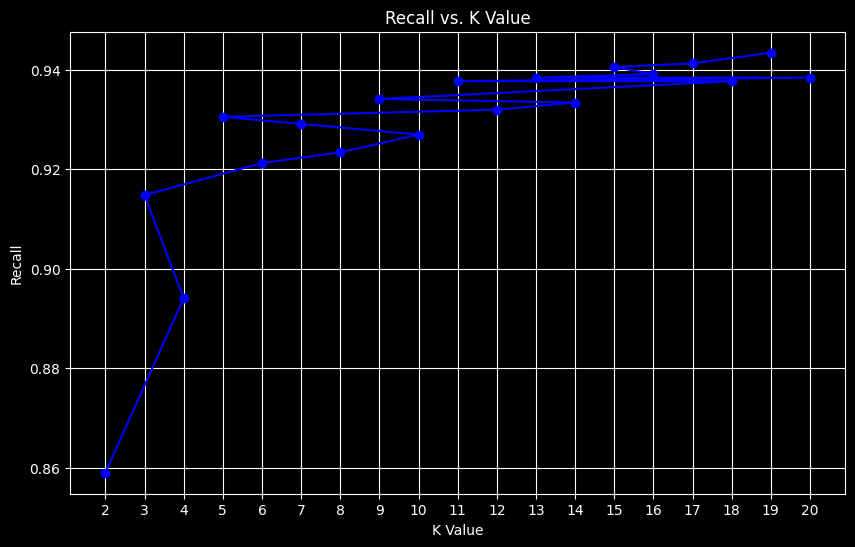

,recall
19,0.943450
17,0.941303
15,0.940587
16,0.939155
13,0.938440
20,0.938440
11,0.937724
18,0.937724
9,0.934145
14,0.933429


In [89]:
recall_df = findBestKBasedOnRecall('results/recall_dict_basic.csv', X_train, y_train, X_valid, y_valid)
recall_df

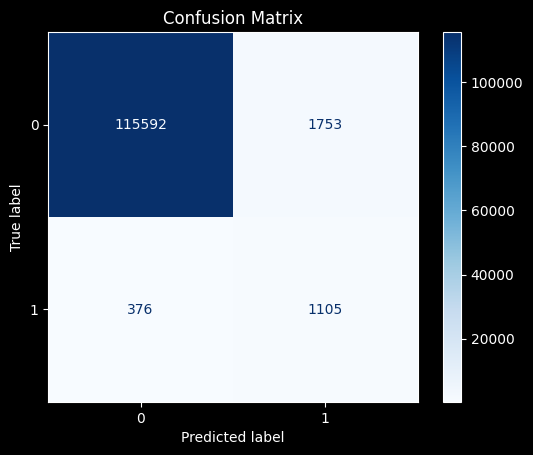

In [90]:
# get the best k value
k = recall_df.index[0]  # Number of neighbours

# name that we gave to the "algo" instance
neighbours_clf = KNeighborsClassifier(n_neighbors=k)
# Fit the model on the training set
neighbours_clf.fit(X_train, y_train)

#show results on the test set
confMat = confusion_matrix(y_test, neighbours_clf.predict(X_test))
confusion_matrix_display = ConfusionMatrixDisplay(confMat, display_labels=neighbours_clf.classes_)
confusion_matrix_display.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [91]:
#print accuracy, precision, recall, f1 score 
print(f"Accuracy: {accuracy_score(y_test, neighbours_clf.predict(X_test)):.4f}")
print(f"Precision: {precision_score(y_test, neighbours_clf.predict(X_test)):.4f}")
print(f"Recall: {recall_score(y_test, neighbours_clf.predict(X_test)):.4f}")
print(f"F1 Score: {f1_score(y_test, neighbours_clf.predict(X_test)):.4f}")

Accuracy: 0.9821
Precision: 0.3866
Recall: 0.7461
F1 Score: 0.5093


### 4.1.2. With PCA

KNN is strongly affected by curse of dimensionality, so we try reducing dimension

In [92]:
# retry with pca
# Create a PCA instance: pca
pca = PCA(n_components=3)
# Fit the PCA instance to the training data
pca.fit(X_train)
# Transform the training data: X_train_pca
X_train_pca = pca.transform(X_train)
# Transform the validation data: X_valid_pca
X_valid_pca = pca.transform(X_valid)
# Transform the test data: X_test_pca
X_test_pca = pca.transform(X_test)

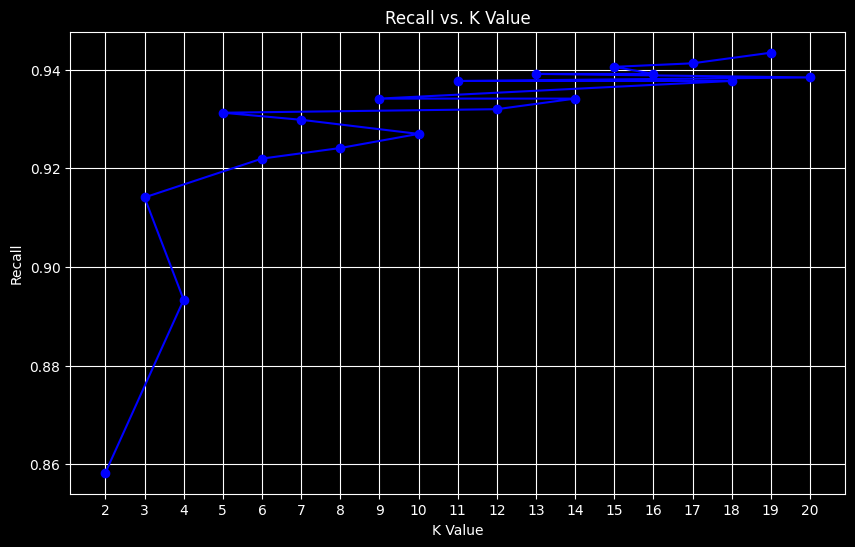

In [93]:
recall_df = findBestKBasedOnRecall('results/recall_dict_pca.csv', X_train_pca, y_train, X_valid_pca, y_valid)

In [94]:
recall_df

,recall
19,0.943450
17,0.941303
15,0.940587
16,0.939155
13,0.939155
20,0.938440
11,0.937724
18,0.937724
9,0.934145
14,0.934145


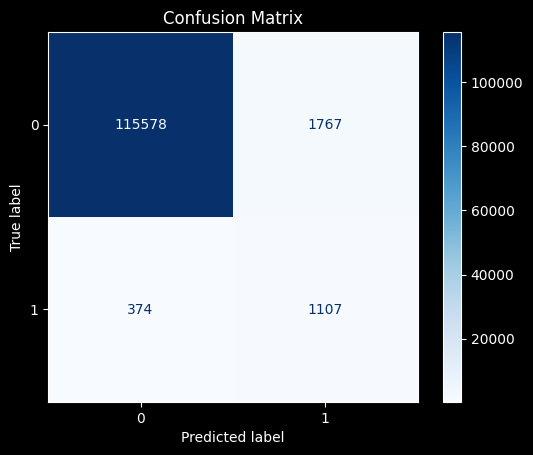

In [95]:
# get the best k value
k = recall_df.index[0]  # Number of neighbours

# name that we gave to the "algo" instance
neighbours_clf_pca = KNeighborsClassifier(n_neighbors=k)
# Fit the model on the training set
neighbours_clf_pca.fit(X_train_pca, y_train)

#show results on the test set
confMat = confusion_matrix(y_test, neighbours_clf_pca.predict(X_test_pca))
confusion_matrix_display = ConfusionMatrixDisplay(confMat, display_labels=neighbours_clf_pca.classes_)
confusion_matrix_display.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [96]:
#print accuracy, precision, recall, f1 score 
print(f"Accuracy: {accuracy_score(y_test, neighbours_clf_pca.predict(X_test_pca)):.4f}")
print(f"Precision: {precision_score(y_test, neighbours_clf_pca.predict(X_test_pca)):.4f}")
print(f"Recall: {recall_score(y_test, neighbours_clf_pca.predict(X_test_pca)):.4f}")
print(f"F1 Score: {f1_score(y_test, neighbours_clf_pca.predict(X_test_pca)):.4f}")

Accuracy: 0.9820
Precision: 0.3852
Recall: 0.7475
F1 Score: 0.5084


### 4.1.3. With Pca & weights based on distance

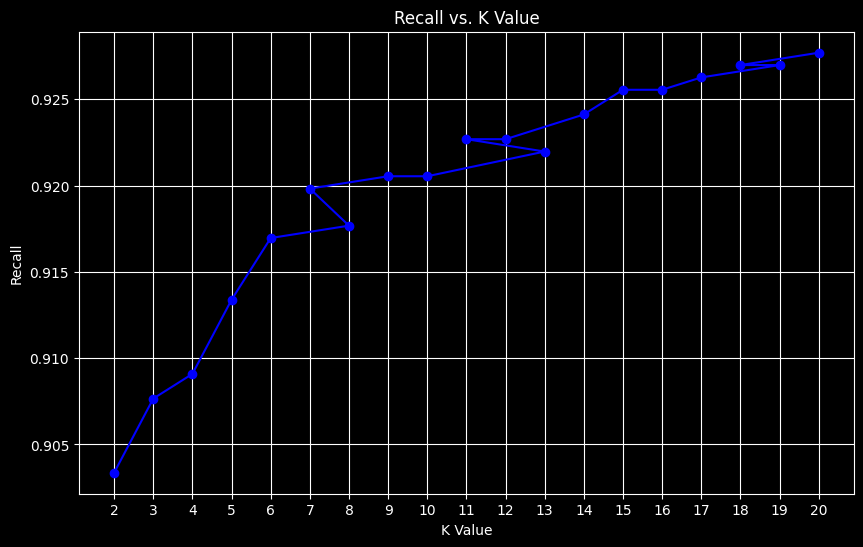

,recall
20,0.927702
18,0.926986
19,0.926986
17,0.926271
16,0.925555
15,0.925555
14,0.924123
12,0.922691
11,0.922691
13,0.921976


In [97]:
recall_df = findBestKBasedOnRecall('results/recall_dict_pca_dist.csv', X_train_pca, y_train, X_valid_pca, y_valid, w='distance')
recall_df

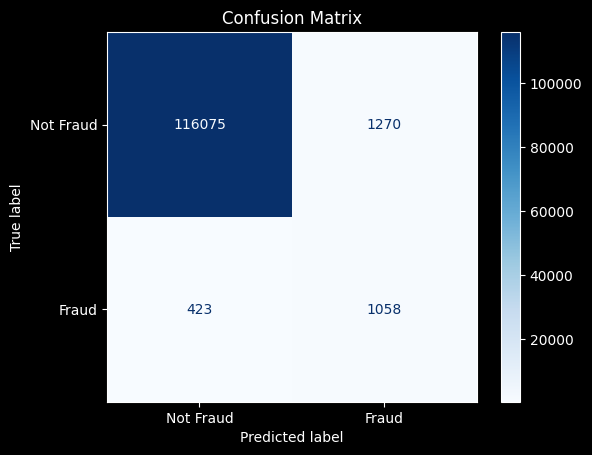

In [98]:
k = recall_df.index[0]  # Number of neighbours

# name that we gave to the "algo" instance
neighbours_clf_pca_weighted = KNeighborsClassifier(n_neighbors=k, weights='distance')
# Fit the model on the training set
neighbours_clf_pca_weighted.fit(X_train_pca, y_train)

#show results on the test set
confMat = confusion_matrix(y_test, neighbours_clf_pca_weighted.predict(X_test_pca))
confusion_matrix_display = ConfusionMatrixDisplay(confMat, display_labels=['Not Fraud', 'Fraud'])
confusion_matrix_display.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [99]:
#print accuracy, precision, recall, f1 score 
print(f"Accuracy: {accuracy_score(y_test, neighbours_clf_pca_weighted.predict(X_test_pca)):.4f}")
print(f"Precision: {precision_score(y_test, neighbours_clf_pca_weighted.predict(X_test_pca)):.4f}")
print(f"Recall: {recall_score(y_test, neighbours_clf_pca_weighted.predict(X_test_pca)):.4f}")
print(f"F1 Score: {f1_score(y_test, neighbours_clf_pca_weighted.predict(X_test_pca)):.4f}")

Accuracy: 0.9858
Precision: 0.4545
Recall: 0.7144
F1 Score: 0.5555


## 4.2. Logistic Regression

In [ ]:
pipeline_instance = Pipeline([('scaler', MaxAbsScaler()), ('classifier', LogisticRegression())])

param_grid = [{
    'classifier': [LogisticRegression(max_iter=1000, class_weight='balanced')],
    #using balanced weights is the best choice, since the dataset classes are extremely inbalanced 
    'classifier__penalty': ['l2'],
    'classifier__C': [0.001, 0.01, 0.1, 1, 10],
    'classifier__solver': ['lbfgs', 'saga']
}]


In [116]:
model = None
if os.path.exists('results/logistic_regression_model.pkl'):
    #load the model
    model = joblib.load('results/logistic_regression_model.pkl')
else:
    grid = GridSearchCV(
        estimator=pipeline_instance,
        param_grid=param_grid,
        scoring=make_scorer(recall_score), #score based on recall
        cv=5,
        n_jobs=-1,
        verbose=1
    )

    grid.fit(X, y)
    #save the model
    joblib.dump(grid.best_estimator_, 'results/logistic_regression_model.pkl')
    model = grid.best_estimator_


Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [117]:
model

Pipeline(steps=[('scaler', MaxAbsScaler()),
                ('classifier',
                 LogisticRegression(C=0.001, class_weight='balanced',
                                    max_iter=1000))])

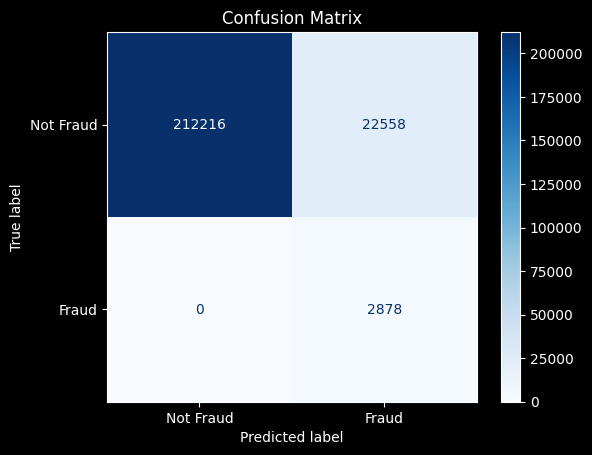

Accuracy: 0.9051
Precision: 0.1131
Recall: 1.0000
F1 Score: 0.2033
              precision    recall  f1-score   support

   Not Fraud       1.00      0.90      0.95    234774
       Fraud       0.11      1.00      0.20      2878

    accuracy                           0.91    237652
   macro avg       0.56      0.95      0.58    237652
weighted avg       0.99      0.91      0.94    237652



In [119]:
# create a new split, to evaluate the best estimator 
# (we don't use the split used in knn because in the best estimator we have included scaling and weighted LR model
# and initial KNN split is scaled and SMOTE is applied on them)
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X, y, test_size=0.4, random_state=42)
model.fit(X_train_lr, y_train_lr)
y_pred = model.predict(X_test_lr)

#plot confusion matrix
confMat = confusion_matrix(y_test_lr, y_pred)
confusion_matrix_display = ConfusionMatrixDisplay(confMat, display_labels=['Not Fraud', 'Fraud'])
confusion_matrix_display.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

#print accuracy, precision, recall, f1 score
print(f"Accuracy: {accuracy_score(y_test_lr, y_pred):.4f}")
print(f"Precision: {precision_score(y_test_lr, y_pred):.4f}")
print(f"Recall: {recall_score(y_test_lr, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test_lr, y_pred):.4f}")

#print classification report
print(classification_report(y_test_lr, y_pred, target_names=['Not Fraud', 'Fraud']))

## 4.4. svm

In [ ]:
# #apply svm
# # Adjust the class weight to handle class imbalance and potentially increase recall
# svc = SVC(kernel='linear', C=1.0, class_weight='balanced', random_state=42)
# # Create a SVC instance: svc
# # svc = SVC(kernel='linear', C=1.0, random_state=42)
# # Fit the SVC instance to the training data
# svc.fit(X_train_pca, y_train)
# # Predict the labels of the test data: y_pred
# y_pred = svc.predict(X_test_pca)

In [ ]:
# # Compute the confusion matrix: confMat
# confMat = confusion_matrix(y_test, y_pred)
# confusion_matrix_display = ConfusionMatrixDisplay(confMat, display_labels=svc.classes_)
# confusion_matrix_display.plot(cmap='Blues')
# plt.title('Confusion Matrix')
# plt.show()

In [ ]:
# #print accuracy, precision, recall, f1 score
# print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
# print(f"Precision: {precision_score(y_test, y_pred):.4f}")
# print(f"Recall: {recall_score(y_test, y_pred):.4f}")
# print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
# print(classification_report(y_test, y_pred, target_names=['Not Fraud', 'Fraud']))


## 4.5 random forest

In [ ]:
# apply random forest
from sklearn.ensemble import RandomForestClassifier

# Create a RandomForestClassifier instance: rf
rf = RandomForestClassifier(n_estimators=100, random_state=42)
# Fit the RandomForestClassifier instance to the training data
rf.fit(X_train_pca, y_train)
# Predict the labels of the test data: y_pred
y_pred = rf.predict(X_test_pca)

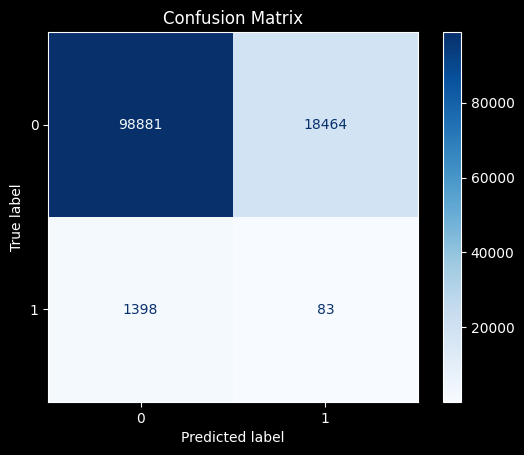

In [ ]:
# Compute the confusion matrix: confMat
confMat = confusion_matrix(y_test, y_pred)
confusion_matrix_display = ConfusionMatrixDisplay(confMat, display_labels=rf.classes_)
confusion_matrix_display.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
#print accuracy, precision, recall, f1 score
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred, target_names=['Not Fraud', 'Fraud']))

Accuracy: 0.8328
Precision: 0.0045
Recall: 0.0560
F1 Score: 0.0083
              precision    recall  f1-score   support

   Not Fraud       0.99      0.84      0.91    117345
       Fraud       0.00      0.06      0.01      1481

    accuracy                           0.83    118826
   macro avg       0.50      0.45      0.46    118826
weighted avg       0.97      0.83      0.90    118826



## 4.6. xgboost

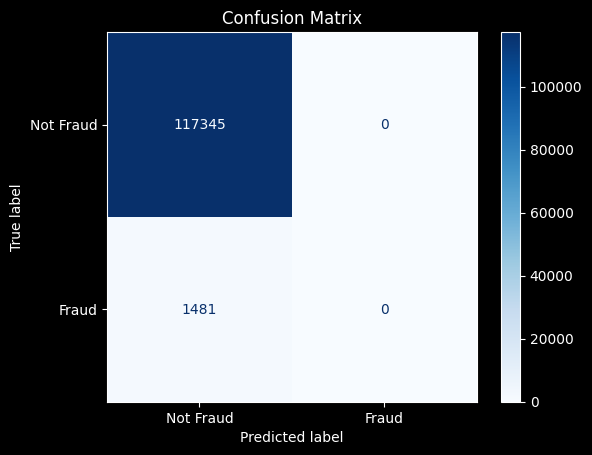

Accuracy: 0.9875
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
              precision    recall  f1-score   support

   Not Fraud       0.99      1.00      0.99    117345
       Fraud       0.00      0.00      0.00      1481

    accuracy                           0.99    118826
   macro avg       0.49      0.50      0.50    118826
weighted avg       0.98      0.99      0.98    118826



c:\Developer\MSC\semester B\Python\venvs\.venv-assignment\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Developer\MSC\semester B\Python\venvs\.venv-assignment\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Developer\MSC\semester B\Python\venvs\.venv-assignment\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, m

In [ ]:
# apply xgboost
# Create an XGBClassifier instance: xgb
xgb = XGBClassifier(eval_metric='logloss', random_state=42)

# Fit the XGBClassifier instance to the training data
xgb.fit(X_train, y_train)
# Predict the labels of the test data: y_pred
y_pred = xgb.predict(X_test)
# Compute the confusion matrix: confMat
confMat = confusion_matrix(y_test, y_pred)
confusion_matrix_display = ConfusionMatrixDisplay(confMat, display_labels=['Not Fraud', 'Fraud'])
confusion_matrix_display.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()
#print accuracy, precision, recall, f1 score
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred, target_names=['Not Fraud', 'Fraud']))